## Neural Network Notebook
---

This notebook builds a neural network to classify heart sounds. The network is defined from scratch using PyTorch. It is trained using different types of features. The sections of the notebook are:

1. [Data Loading](#Data-Loading)
2. [Fit Model](#Fit-Model)

#### Results
| Model Name | Features | Accuracy |
| --- | --- | --- |


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from utils import *

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

# -------- tqdm DARK THEME --------

In [3]:
# data characteristics
frame_length = 1
sample_rate = 'mix'
n_mfcc = 20
batch_size = 32

# set the paths
FEATURES_DIR = '../features'
FEATURES_RAW_DIR = '../features/raw/'
FEATURES_BAL_PRIOR_DIR = '../features/balanced/priori/'
FEATURES_BAL_POST_DIR = '../features/balanced/posteriori/'
FEATURES_NAME = f'full_data_{frame_length}_{sample_rate}_{n_mfcc}.npy'

MODEL_DIR = '../models/'
MODEL_CHECKPOINT_DIR = MODEL_DIR + 'checkpoints/'

### 1. Data Loading

In [4]:
# load the data
full_data_bal = np.load(os.path.join(FEATURES_BAL_POST_DIR, FEATURES_NAME), allow_pickle=True).item()

# plot the structure of the dictionary
print(full_data_bal.keys())
print(full_data_bal['train_bal'].keys())

# get the data
train_unb = full_data_bal['train_unb']
X_train_unb = torch.tensor(train_unb['X'], dtype=torch.float32)
y_train_unb = torch.tensor(train_unb['y'], dtype=torch.long)
train_unb_ds = torch.utils.data.TensorDataset(X_train_unb, y_train_unb)
train_unb_dl = torch.utils.data.DataLoader(train_unb_ds, batch_size=batch_size, shuffle=True)

train_bal = full_data_bal['train_bal']
X_train_bal = torch.tensor(train_bal['X'], dtype=torch.float32)
y_train_bal = torch.tensor(train_bal['y'], dtype=torch.long)
train_bal_ds = torch.utils.data.TensorDataset(X_train_bal, y_train_bal)
train_bal_dl = torch.utils.data.DataLoader(train_bal_ds, batch_size=batch_size, shuffle=True)

test = full_data_bal['test']
X_test = torch.tensor(test['X'], dtype=torch.float32)
y_test = torch.tensor(test['y'], dtype=torch.long)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

dict_keys(['train_unb', 'train_bal', 'test'])
dict_keys(['X', 'y', 'filename'])


### 2. Fit Model

In [5]:
# define the model
# define a simple feedforward neural network

input_size = train_unb_dl.dataset.tensors[0].shape[1]
output_size = 5
hid_1, hid_2, hid_3 = 128, 64, 32
print(f"Input size: {input_size}, Output size: {output_size}")

class NN(nn.Module):
	def __init__(self):
		super().__init__()
		self.model = nn.Sequential(
			nn.Linear(input_size, hid_1),
			nn.ReLU(),
			nn.Linear(hid_1, hid_2),
			nn.ReLU(),
			nn.Linear(hid_2, hid_3),
			nn.ReLU(),
			nn.Linear(hid_3, output_size)
		)
  
	def forward(self, x):
		return self.model(x)

print(NN())

# get number of parameters
model = NN()
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Input size: 26, Output size: 5
NN(
  (model): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=5, bias=True)
  )
)
Number of parameters: 13957


In [6]:
# Instantiate the model
model = NN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = get_device()

# Training loop
epochs = 100
MODEL_NAME = f'NN_{frame_length}_{sample_rate}_{n_mfcc}__{hid_1}_{hid_2}_{hid_3}__{output_size}'
EXT = '.pth'

# data to valuate the model
evaluation_data = test_dl

train_loss_list, train_acc_list, test_loss_list, test_acc_list = fit_model(epochs, train_bal_dl, evaluation_data, model, loss_func, optimizer, device , model_path_store = MODEL_DIR+MODEL_NAME, path_to_store=MODEL_CHECKPOINT_DIR+MODEL_NAME, get_loss_acc=True, evaluation_epochs = 1)

# prior to save check if the model is already saved. if so, ask the user if they want to overwrite it
if os.path.exists(MODEL_DIR+MODEL_NAME+EXT):
    print(f"Model {MODEL_NAME} already exists in the path {MODEL_DIR}. It will be saved as a new model.")
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(MODEL_DIR+MODEL_NAME+'_new'+EXT)
    print(f"Saved PyTorch Model State to {MODEL_NAME+'_new'}")
else:
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(MODEL_DIR+MODEL_NAME+EXT)
    print(f"Saved PyTorch Model State to {MODEL_NAME}")


Using cpu device


  0%|          | 0/100 [00:00<?, ?it/s]

loss: 42.758999 - acc: 21.88% [   32/ 7500]
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 59.5%, Avg loss: 1.197733 

loss: 1.239925 - acc: 68.75% [   32/ 7500]
Epoch 2
-------------------------------
Test Error: 
 Accuracy: 61.0%, Avg loss: 1.124208 

loss: 1.203711 - acc: 65.62% [   32/ 7500]
Epoch 3
-------------------------------
Test Error: 
 Accuracy: 68.5%, Avg loss: 1.058140 

loss: 0.838310 - acc: 87.50% [   32/ 7500]
Epoch 4
-------------------------------
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.171781 

loss: 0.598536 - acc: 78.12% [   32/ 7500]
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.796738 

loss: 0.490465 - acc: 81.25% [   32/ 7500]
Epoch 6
-------------------------------
Test Error: 
 Accuracy: 69.0%, Avg loss: 1.193637 

loss: 0.452228 - acc: 84.38% [   32/ 7500]
Epoch 7
-------------------------------
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.655565 

loss: 0.293398 - acc: 93.75% [   32/ 7500]
Epoch 8
---

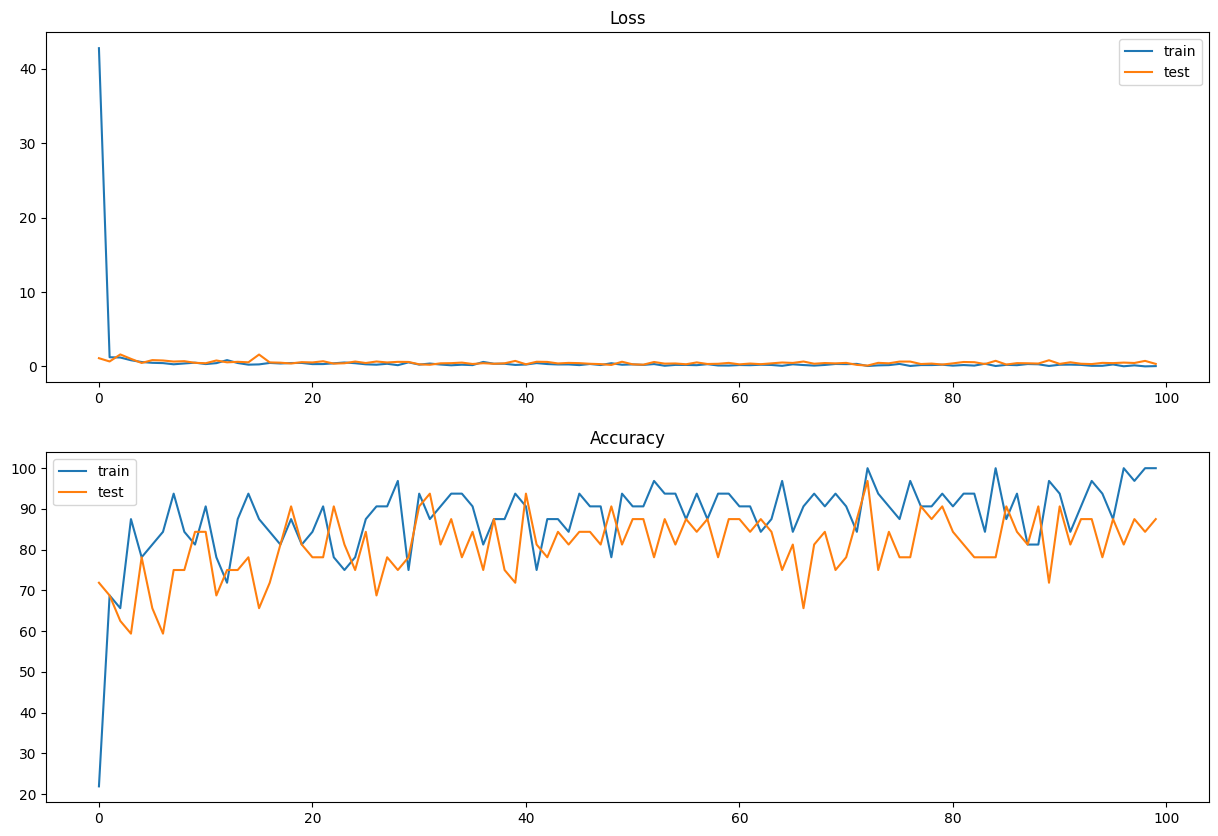

In [7]:
# get the key for val_dl from full_data
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.lineplot(train_loss_list, label='train', ax=axs[0])
sns.lineplot(test_loss_list, label='test', ax=axs[0])
_ = axs[0].set_title('Loss')


sns.lineplot(train_acc_list, label='train', ax=axs[1])
sns.lineplot(test_acc_list, label='test', ax=axs[1])
_ = axs[1].set_title('Accuracy')


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       240
           1       0.95      0.89      0.92       177
           2       0.77      0.73      0.75       230
           3       0.76      0.83      0.80       432
           4       0.81      0.74      0.77       161

    accuracy                           0.84      1240
   macro avg       0.85      0.83      0.84      1240
weighted avg       0.84      0.84      0.84      1240



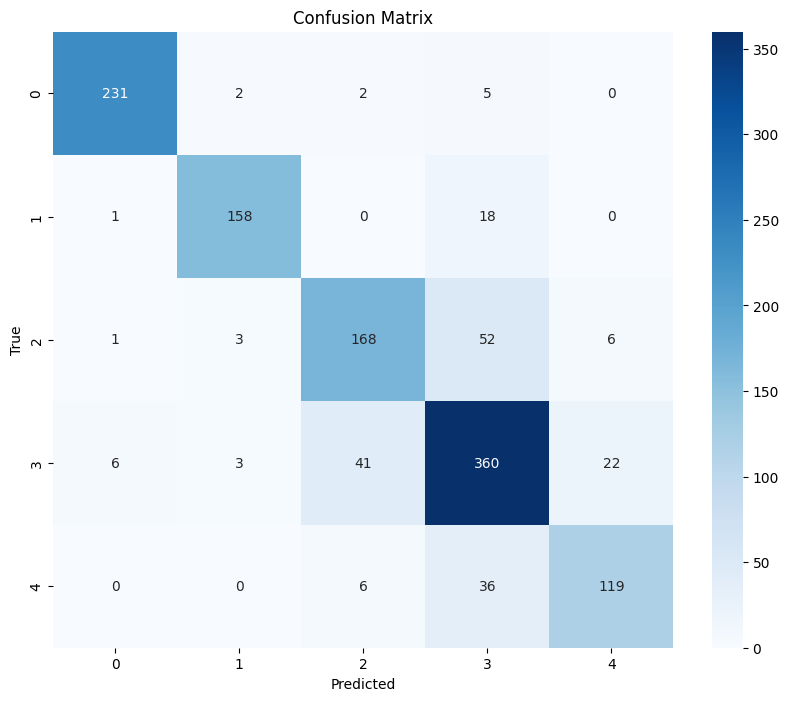

In [10]:
# load the model
model = torch.jit.load(MODEL_DIR+MODEL_NAME + EXT)

# evaluate the model
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
	for X_batch, y_batch in test_dl:
		y_pred_batch = model(X_batch)
		y_pred.append(y_pred_batch.argmax(dim=1).cpu().numpy())
		y_true.append(y_batch.cpu().numpy())

# compute the confusion matrix
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
cf = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# get the classification report
print(classification_report(y_true, y_pred))